# 제품 이상 여부 판별 프로젝트

# 1. 데이터 & 라이브러리 불러오기

In [90]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings; warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

### 데이터 읽어오기

In [91]:
ROOT_DIR = "data"
RANDOM_STATE = 77

# Load data
train_data = pd.read_csv(os.path.join("data/train.csv"))
test_data = pd.read_csv(os.path.join("data/test.csv"))
print("train shape : ", train_data.shape)
print("test shape : ", test_data.shape)

train shape :  (40506, 468)
test shape :  (17361, 469)


In [92]:
df_hand = pd.read_excel(os.path.join(ROOT_DIR, "hand_data.xlsx"))
df_hand.head(6)

,day,start_time,end_time,Dam Thickness - 1time / day,Fill thickness - 1time / day,Fill cure energy (mJ) - Every break time,Fill cure power (mW) - Every break time,Line Temp. - Every break time,Line humidity - Every break time,OCR gap - Line#1 stage1,OCR gap - Line#1 stage2,OCR gap - Line#1 stage3,OCR gap - Line #2 stage1,OCR gap - Line #2 stage2,OCR gap - Line #2 stage3
0,240319,08:00:00,10:30:00,454.0,193.0,1728.0,2919.0,23.4,56.6,1.2,1.0,1.2,1.2,0.9,1.4
1,240319,10:45:00,12:00:00,454.0,193.0,1754.0,2962.0,24.0,50.9,1.2,1.0,1.2,1.2,0.9,1.4
2,240319,13:00:00,15:00:00,454.0,193.0,1708.0,2887.0,24.5,49.6,1.2,1.0,1.2,1.2,0.9,1.4
3,240319,15:15:00,18:00:00,454.0,193.0,1751.0,2946.0,24.7,53.4,1.2,1.0,1.2,1.2,1.2,1.4
4,240319,18:30:00,20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,240320,08:00:00,10:30:00,481.0,212.0,1739.0,2875.0,24.2,55.6,1.2,1.0,1.2,1.2,1.2,1.4


# 2. 데이터 전처리 - 1

### Null값 확인

In [93]:
train_data.isna().sum()

Wip Line_Dam                         0
Process Desc._Dam                    0
Equipment_Dam                        0
Model.Suffix_Dam                     0
Workorder_Dam                        0
                                 ...  
Receip No Judge Value_Fill2      40506
WorkMode Collect Result_Fill2        0
WorkMode Unit Time_Fill2         40506
WorkMode Judge Value_Fill2       40506
target                               0
Length: 468, dtype: int64

### Null이 50%이상인 컬럼제거


In [94]:
# Null 값이 포함된 컬럼만 추출
null_columns = train_data.columns[train_data.isna().any()]

# Null 값이 포함된 컬럼들의 null 값 개수 확인
null_counts = train_data[null_columns].isna().sum()

# Drop columns with more than half of the values missing
drop_cols = []
for column in train_data.columns:
    if (train_data[column].notnull().sum() // 2) < train_data[
        column
    ].isnull().sum():
        drop_cols.append(column)
train_data = train_data.drop(drop_cols, axis=1)
print("train shape : ", train_data.shape)

train shape :  (40506, 185)


In [95]:
features = []
for col in train_data.columns:
    try:
        features.append(col)
    except:
        continue

In [96]:
test_data = test_data[features]
print("test shape : ", test_data.shape)

test shape :  (17361, 185)


# 3. 데이터 전처리 - 2

### 다시 NULL값 확인


In [97]:
# Null 값이 포함된 컬럼만 추출
null_columns = train_data.columns[train_data.isna().any()]

# Null 값이 포함된 컬럼들의 null 값 개수 확인
null_counts = train_data[null_columns].isna().sum()

null_counts

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    12766
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    12766
dtype: int64

In [98]:
# 컬럼 이름 설정
columns_of_interest = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]

# 각 컬럼의 유니크 값 찾기
for column in columns_of_interest:
    unique_values = train_data[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print()  # 빈 줄 추가

Unique values in column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam':
[nan '550.3' 'OK' '162.4' '549' '549.5' '550' '548.5']

Unique values in column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1':
[nan '838.4' 'OK' '837.7' '837.9' '838.2' '837.5']

Unique values in column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2':
[nan '835.5' 'OK' '305']



NULL, 숫자형, 범주형 변수가 섞여있음 -> 데이터가 밀린것을 확인

### 데이터 밀려있는부분 전처리

#### Train - Dam 밀린부분 처리

In [99]:
# Dam 안밀린부분 떼어내기
D0 = train_data.iloc[:, :25]

# Dam 밀린부분 작업해주기
Dam1 = train_data[(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] == "OK") |
                  (pd.isna(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam']))]
Dam2 = train_data[(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] != "OK") &
                  (~pd.isna(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam']))]

Dam_col = train_data.columns[25:78]

D1 = Dam1[Dam_col]
D1 = D1.iloc[:, 1:]
D1['new'] = 7
D1.columns = Dam_col
D2 = Dam2[Dam_col]
D = pd.concat([D1, D2])

#### Train - AutoClave 밀린부분 처리

In [100]:
# Auto Clave는 안밀려있음
Auto = train_data.iloc[:, 78:98]

#### Train - Fill1 밀린부분 처리

In [101]:
# Fill1 안밀린부분 작업해주기
F1_0 = train_data.iloc[:, 98:113]

# Fill1 밀린부분 작업해주기
Fill1_1 = train_data[(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] == "OK") |
               (pd.isna(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']))]
Fill1_2 = train_data[(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] != "OK") &
               (~pd.isna(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']))]

Fill1_col = train_data.columns[113:136]
F1_1 = Fill1_1[Fill1_col]
F1_1 = F1_1.iloc[:, 1:]
F1_1['new'] = 7
F1_1.columns = Fill1_col
F1_2 = Fill1_2[Fill1_col]
FF1 = pd.concat([F1_1, F1_2])

#### Train - Fill2 밀린부분 처리

In [102]:
# Fill2 안밀린부분 작업해주기
F2_0 = train_data.iloc[:, 136:161]
F2_0
# Fill2 밀린부분 작업해주기
Fill2_1 = train_data[(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] == "OK") |
               (pd.isna(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']))]
Fill2_2 = train_data[(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] != "OK") &
               (~pd.isna(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']))]

Fill2_col = train_data.columns[161:184]
F2_1 = Fill2_1[Fill2_col]
F2_1 = F2_1.iloc[:, 1:]
F2_1['new'] = 0
F2_1.columns = Fill2_col
F2_2 = Fill2_2[Fill2_col]
FF2 = pd.concat([F2_1, F2_2])

### Train data 병합

In [103]:
# target
target = train_data.iloc[:, 184]

# 병합
train_data = pd.concat([D0, D, Auto, F1_0, FF1, F2_0, FF2, target], axis=1)

In [104]:
# Null 값이 포함된 컬럼만 추출
null_columns = train_data.columns[train_data.isna().any()]

# Null 값이 포함된 컬럼들의 null 값 개수 확인
null_counts = train_data[null_columns].isna().sum()

null_counts

Series([], dtype: float64)

NULL 값이 없는것을 확인

### Test data도 동일하게 처리

In [105]:
# Dam 안밀린부분 떼어내기
D0 = test_data.iloc[:, :25]

# Dam 밀린부분 작업해주기
Dam1 = test_data[(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] == "OK") |
                  (pd.isna(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam']))]
Dam2 = test_data[(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] != "OK") &
                  (~pd.isna(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam']))]

Dam_col = test_data.columns[25:78]

D1 = Dam1[Dam_col]
D1 = D1.iloc[:, 1:]
D1['new'] = 7
D1.columns = Dam_col
D2 = Dam2[Dam_col]
D = pd.concat([D1, D2])

In [106]:
# Auto Clave는 안밀려있음
Auto = test_data.iloc[:, 78:98]

In [107]:
# Fill1 안밀린부분 작업해주기
F1_0 = test_data.iloc[:, 98:113]

# Fill1 밀린부분 작업해주기
Fill1_1 = test_data[(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] == "OK") |
               (pd.isna(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']))]
Fill1_2 = test_data[(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] != "OK") &
               (~pd.isna(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']))]

Fill1_col = test_data.columns[113:136]
Fill1_col
F1_1 = Fill1_1[Fill1_col]
F1_1 = F1_1.iloc[:, 1:]
F1_1['new'] = 7
F1_1.columns = Fill1_col
F1_2 = Fill1_2[Fill1_col]
FF1 = pd.concat([F1_1, F1_2])

In [108]:
# Fill2 안밀린부분 작업해주기
F2_0 = test_data.iloc[:, 136:161]
F2_0
# Fill2 밀린부분 작업해주기
Fill2_1 = test_data[(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] == "OK") |
               (pd.isna(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']))]
Fill2_2 = test_data[(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] != "OK") &
               (~pd.isna(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']))]

Fill2_col = test_data.columns[161:184]

F2_1 = Fill2_1[Fill2_col]
F2_1 = F2_1.iloc[:, 1:]
F2_1['new'] = 0
F2_1.columns = Fill2_col
F2_2 = Fill2_2[Fill2_col]
FF2 = pd.concat([F2_1, F2_2])

In [109]:
# 병합
test_data = pd.concat([D0, D, Auto, F1_0, FF1, F2_0, FF2], axis=1)

In [110]:
# Null 값이 포함된 컬럼만 추출
null_columns = test_data.columns[test_data.isna().any()]

# Null 값이 포함된 컬럼들의 null 값 개수 확인
null_counts = test_data[null_columns].isna().sum()

null_counts

Series([], dtype: float64)

### 데이터 타입 통일

In [111]:
# 숫자형과 문자열이 섞여있는 열을 찾고 숫자형으로 변환
for column in train_data.columns:
    if train_data[column].apply(lambda x: isinstance(x, (int, float))).any() and train_data[column].apply(lambda x: isinstance(x, str)).any():
        train_data[column] = pd.to_numeric(train_data[column], errors='coerce')

In [112]:
# 숫자형과 문자열이 섞여있는 열을 찾고 숫자형으로 변환
for column in test_data.columns:
    if test_data[column].apply(lambda x: isinstance(x, (int, float))).any() and test_data[column].apply(lambda x: isinstance(x, str)).any():
        test_data[column] = pd.to_numeric(test_data[column], errors='coerce')

# 4. 데이터 전처리 - 3

In [113]:
# 불필요한 변수 제거
def variable_cleanup(data):
    # Workorder
    data_cleaned = data.drop(columns=['Workorder_Fill1', 'Workorder_AutoClave', 'Workorder_Fill2'])
    data_cleaned = data_cleaned.rename(columns={'Workorder_Dam': 'Workorder'})

    # Model.Suffix
    data_cleaned = data_cleaned.drop(columns=['Model.Suffix_Fill1', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill2'])
    data_cleaned = data_cleaned.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

    # Wip Line, Process Desc, Insp. Seq No., Insp Judge Code, WorkMode , Equipment_AutoClave
    data_cleaned = data_cleaned.drop(columns=[
        'Wip Line_Dam', 'Wip Line_Fill1', 'Wip Line_AutoClave', 'Wip Line_Fill2',
        'Process Desc._Dam', 'Process Desc._Fill1', 'Process Desc._AutoClave', 'Process Desc._Fill2',
        'Insp. Seq No._Dam', 'Insp. Seq No._Fill1', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill2',
        'Insp Judge Code_Dam', 'Insp Judge Code_Fill1', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill2',
        'WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2',
        'Equipment_AutoClave'
    ])

    # unique value = 0 또는 OK (only, 좌표 조합은 제외)
    data_cleaned = data_cleaned.drop(columns=[
        'DISCHARGED SPEED OF RESIN Collect Result_Fill2', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
        'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
        'Dispense Volume(Stage1) Collect Result_Fill2', 'Dispense Volume(Stage2) Collect Result_Fill2', 'Dispense Volume(Stage3) Collect Result_Fill2',
        '1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave', '3rd Pressure Judge Value_AutoClave'
    ])

    # 새로운 column drop
    data_cleaned = data_cleaned.drop(columns=[
        'CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION Θ Collect Result_Dam',
        'CURE START POSITION Z Collect Result_Dam',
        'HEAD Standby Position X Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam',
        'Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam',
        'Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam',
        'Head Zero Position X Collect Result_Dam',
        'HEAD Standby Position X Collect Result_Fill1','HEAD Standby Position Y Collect Result_Fill1','HEAD Standby Position Z Collect Result_Fill1',
        'Head Clean Position X Collect Result_Fill1','Head Clean Position Y Collect Result_Fill1','Head Clean Position Z Collect Result_Fill1',
        'Head Purge Position X Collect Result_Fill1','Head Purge Position Y Collect Result_Fill1',
        'CURE END POSITION Θ Collect Result_Fill2',
        'CURE STANDBY POSITION X Collect Result_Fill2', 'CURE STANDBY POSITION Θ Collect Result_Fill2',
        'CURE START POSITION Θ Collect Result_Fill2',
        'HEAD Standby Position X Collect Result_Fill2','HEAD Standby Position Y Collect Result_Fill2','HEAD Standby Position Z Collect Result_Fill2',
        'Head Clean Position X Collect Result_Fill2','Head Clean Position Y Collect Result_Fill2','Head Clean Position Z Collect Result_Fill2',
        'Head Purge Position X Collect Result_Fill2','Head Purge Position Y Collect Result_Fill2'
    ])

    return data_cleaned

train_data = variable_cleanup(train_data); test_data = variable_cleanup(test_data)
print(train_data.shape); print(test_data.shape)

(40506, 117)
(17361, 116)


# 5. 데이터 전처리 - 4

In [114]:
# durations
train_data['Collect Date_Dam'] = pd.to_datetime(train_data['Collect Date_Dam'])
train_data['Collect Date_AutoClave'] = pd.to_datetime(train_data['Collect Date_AutoClave'])
train_data['Collect Date_Fill1'] = pd.to_datetime(train_data['Collect Date_Fill1'])
train_data['Collect Date_Fill2'] = pd.to_datetime(train_data['Collect Date_Fill2'])
train_data['durations']=train_data['Collect Date_AutoClave'] - train_data['Collect Date_Dam']
train_data['day_Dam'] = train_data['Collect Date_Dam'].dt.strftime('%y%m%d')

test_data['Collect Date_Dam'] = pd.to_datetime(test_data['Collect Date_Dam'])
test_data['Collect Date_AutoClave'] = pd.to_datetime(test_data['Collect Date_AutoClave'])
test_data['Collect Date_Fill1'] = pd.to_datetime(test_data['Collect Date_Fill1'])
test_data['Collect Date_Fill2'] = pd.to_datetime(test_data['Collect Date_Fill2'])
test_data['durations']=test_data['Collect Date_AutoClave'] - test_data['Collect Date_Dam']
test_data['day_Dam'] = test_data['Collect Date_Dam'].dt.strftime('%y%m%d')

# 각 공정 간의 시간 차이 계산 (분 단위)
train_data['time_diff_Dam_to_Fill1'] = (train_data['Collect Date_Fill1'] - train_data['Collect Date_Dam']).dt.total_seconds() / 60
train_data['time_diff_Fill1_to_Fill2'] = (train_data['Collect Date_Fill2'] - train_data['Collect Date_Fill1']).dt.total_seconds() / 60
train_data['time_diff_Fill2_to_AutoClave'] = (train_data['Collect Date_AutoClave'] - train_data['Collect Date_Fill2']).dt.total_seconds() / 60

# 각 공정 간의 시간 차이 계산 (분 단위)
test_data['time_diff_Dam_to_Fill1'] = (test_data['Collect Date_Fill1'] - test_data['Collect Date_Dam']).dt.total_seconds() / 60
test_data['time_diff_Fill1_to_Fill2'] = (test_data['Collect Date_Fill2'] - test_data['Collect Date_Fill1']).dt.total_seconds() / 60
test_data['time_diff_Fill2_to_AutoClave'] = (test_data['Collect Date_AutoClave'] - test_data['Collect Date_Fill2']).dt.total_seconds() / 60

# 각 공정별 HH:MM 변수
train_data['time_Dam'] = train_data['Collect Date_Dam'].dt.strftime('%H:%M')
test_data['time_Dam'] = test_data['Collect Date_Dam'].dt.strftime('%H:%M')
train_data['time_AutoClave'] = train_data['Collect Date_AutoClave'].dt.strftime('%H:%M')
test_data['time_AutoClave'] = test_data['Collect Date_AutoClave'].dt.strftime('%H:%M')
train_data['time_Fill1'] = train_data['Collect Date_Fill1'].dt.strftime('%H:%M')
test_data['time_Fill1'] = test_data['Collect Date_Fill1'].dt.strftime('%H:%M')
train_data['time_Fill2'] = train_data['Collect Date_Fill2'].dt.strftime('%H:%M')
test_data['time_Fill2'] = test_data['Collect Date_Fill2'].dt.strftime('%H:%M')

### Collect Date drop

In [115]:
train_data = train_data.drop(columns = ['Collect Date_Dam', 'Collect Date_AutoClave', 'Collect Date_Fill1', 'Collect Date_Fill2'])
test_data = test_data.drop(columns = ['Collect Date_Dam', 'Collect Date_AutoClave', 'Collect Date_Fill1', 'Collect Date_Fill2'])

# 6. Tact time 제외하고 모두 범주형 처리

In [116]:
# 범주형 및 연속형 변수 정의
numerical_cols = ['Machine Tact time Collect Result_Fill2', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Dam']
categorical_cols = list(set(train_data.columns) - set(numerical_cols) - set(['target']))
target_col = 'target'

len(categorical_cols)

118

In [117]:
len(numerical_cols) + len(categorical_cols)

121

In [118]:
train_data

,Equipment_Dam,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,...,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,Head Purge Position Z Collect Result_Fill1,Machine Tact time Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,CURE START POSITION X Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Resu

# 4. 모델링

### Train - Validation 구분

In [119]:
# train set, validation set 구분
train_data[categorical_cols] = train_data[categorical_cols].astype('str')
test_data[categorical_cols] = test_data[categorical_cols].astype('str')
train_data['target'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

X = train_data.drop('target', axis=1)
y = train_data['target']

In [120]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import optuna

In [121]:
def CAT(params, seed):

    # 데이터 분할 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

    # 모델 초기화 및 학습(모델 시드는 77로 고정)
    model = CatBoostClassifier(**params, random_state=77, verbose=0, cat_features=categorical_cols, early_stopping_rounds=150)
    # 최종 검증 데이터셋에서 모델 성능 평가
    model.fit(X_train, y_train)
    y_pred_final = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred_final) ; precision = precision_score(y_val, y_pred_final)
    recall = recall_score(y_val, y_pred_final) ; f1_final = f1_score(y_val, y_pred_final)
    conf_matrix = confusion_matrix(y_val, y_pred_final)

    # 결과 출력
    print(f"Accuracy: {accuracy:.4f}") ; print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}") ; print(f"F1 Score: {f1_final:.4f}")
    print("\nConfusion Matrix:") ; print(conf_matrix)

    # 변수 중요도 계산
    feature_importances = model.get_feature_importance()

    # 변수 이름과 중요도 및 nunique 값을 zip으로 묶은 후 중요도 기준으로 내림차순 정렬
    sorted_importances = sorted(zip(X_train.columns, feature_importances, X_train.nunique()), key=lambda x: x[1], reverse=True)

    # 상위 10개 변수 중요도 및 nunique 값 출력
    print("\nTop 10 Feature Importances:")
    for feature_name, importance, nunique in sorted_importances[:10]:
        print(f"Feature: {feature_name}, Importance: {importance:.4f}, Unique Values: {nunique}")

    return f1_final

In [122]:
def objective(trial):
    # Hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 8),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1400),
        'class_weights': [1, trial.suggest_float('class_weights', 7, 11, step=0.1)],
        'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 3, 12),
        'task_type' : 'GPU'
        #,
        #'devices' : '0'
    }

    # 시드 10개 중 무작위 선택
    seed = 1998

    # CAT 함수를 사용해 F1 스코어 반환
    f1_score = CAT(params, seed)

    return f1_score

# Optuna study를 생성하고 최적화 수행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# 최적화된 파라미터 출력
print("Best parameters found: ", study.best_params)

[I 2024-09-28 17:18:27,258] A new study created in memory with name: no-name-c10b1417-0e99-4106-9715-a3611a5f941e


Accuracy: 0.8934
Precision: 0.2062
Recall: 0.2936
F1 Score: 0.2422

Confusion Matrix:
[[10650   797]
 [  498   207]]


[I 2024-09-28 17:19:49,942] Trial 0 finished with value: 0.2422469280280866 and parameters: {'learning_rate': 0.015025539980411855, 'depth': 4, 'n_estimators': 1335, 'class_weights': 9.9, 'l2_leaf_reg': 6}. Best is trial 0 with value: 0.2422469280280866.



Top 10 Feature Importances:
Feature: durations, Importance: 35.4392, Unique Values: 40
Feature: Workorder, Importance: 5.6921, Unique Values: 663
Feature: day_Dam, Importance: 5.1902, Unique Values: 210
Feature: time_diff_Dam_to_Fill1, Importance: 2.4267, Unique Values: 15
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.2554, Unique Values: 37
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, Importance: 2.1139, Unique Values: 15
Feature: Model.Suffix, Importance: 1.7121, Unique Values: 7
Feature: Machine Tact time Collect Result_Dam, Importance: 1.6823, Unique Values: 420
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 1.6074, Unique Values: 26
Feature: PalletID Collect Result_Fill1, Importance: 1.5873, Unique Values: 16
Accuracy: 0.9056
Precision: 0.2318
Recall: 0.2709
F1 Score: 0.2498

Confusion Matrix:
[[10814   633]
 [  514   191]]


[I 2024-09-28 17:21:12,180] Trial 1 finished with value: 0.24983649444081102 and parameters: {'learning_rate': 0.012681182306072018, 'depth': 4, 'n_estimators': 1329, 'class_weights': 9.5, 'l2_leaf_reg': 8}. Best is trial 1 with value: 0.24983649444081102.



Top 10 Feature Importances:
Feature: durations, Importance: 36.7584, Unique Values: 40
Feature: Workorder, Importance: 5.9945, Unique Values: 663
Feature: day_Dam, Importance: 5.8504, Unique Values: 210
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.4284, Unique Values: 37
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, Importance: 2.3151, Unique Values: 15
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 1.6718, Unique Values: 66
Feature: Model.Suffix, Importance: 1.6476, Unique Values: 7
Feature: time_diff_Dam_to_Fill1, Importance: 1.6286, Unique Values: 15
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 1.5845, Unique Values: 26
Feature: 1st Pressure 1st Pressure Unit Time_AutoClave, Importance: 1.5416, Unique Values: 9
Accuracy: 0.9101
Precision: 0.2500
Recall: 0.2752
F1 Score: 0.2620

Confusion Matrix:
[[10865   582]
 [  511   194]]


[I 2024-09-28 17:22:24,870] Trial 2 finished with value: 0.26198514517218097 and parameters: {'learning_rate': 0.07064828182910994, 'depth': 5, 'n_estimators': 983, 'class_weights': 9.1, 'l2_leaf_reg': 12}. Best is trial 2 with value: 0.26198514517218097.



Top 10 Feature Importances:
Feature: durations, Importance: 14.4195, Unique Values: 40
Feature: Workorder, Importance: 4.1263, Unique Values: 663
Feature: day_Dam, Importance: 4.0217, Unique Values: 210
Feature: 1st Pressure Collect Result_AutoClave, Importance: 2.9468, Unique Values: 27
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.8128, Unique Values: 78
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.6310, Unique Values: 26
Feature: Machine Tact time Collect Result_Dam, Importance: 2.3852, Unique Values: 420
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.2460, Unique Values: 335
Feature: time_Dam, Importance: 2.1531, Unique Values: 134
Feature: time_AutoClave, Importance: 2.0619, Unique Values: 135
Accuracy: 0.9330
Precision: 0.3620
Recall: 0.2028
F1 Score: 0.2600

Confusion Matrix:
[[11195   252]
 [  562   143]]


[I 2024-09-28 17:22:57,319] Trial 3 finished with value: 0.25999999999999995 and parameters: {'learning_rate': 0.07543056847620755, 'depth': 7, 'n_estimators': 431, 'class_weights': 9.0, 'l2_leaf_reg': 7}. Best is trial 2 with value: 0.26198514517218097.



Top 10 Feature Importances:
Feature: 1st Pressure Collect Result_AutoClave, Importance: 5.4251, Unique Values: 27
Feature: durations, Importance: 4.8038, Unique Values: 40
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 4.0128, Unique Values: 26
Feature: time_AutoClave, Importance: 3.9104, Unique Values: 135
Feature: Machine Tact time Collect Result_Fill1, Importance: 3.8341, Unique Values: 335
Feature: Machine Tact time Collect Result_Fill2, Importance: 3.4943, Unique Values: 78
Feature: time_Dam, Importance: 3.3628, Unique Values: 134
Feature: Workorder, Importance: 3.3107, Unique Values: 663
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 3.2204, Unique Values: 66
Feature: day_Dam, Importance: 3.1340, Unique Values: 210
Accuracy: 0.9143
Precision: 0.2569
Recall: 0.2525
F1 Score: 0.2546

Confusion Matrix:
[[10932   515]
 [  527   178]]


[I 2024-09-28 17:25:12,305] Trial 4 finished with value: 0.25464949928469244 and parameters: {'learning_rate': 0.04318542662840676, 'depth': 7, 'n_estimators': 1037, 'class_weights': 9.3, 'l2_leaf_reg': 11}. Best is trial 2 with value: 0.26198514517218097.



Top 10 Feature Importances:
Feature: durations, Importance: 13.0092, Unique Values: 40
Feature: Workorder, Importance: 3.9387, Unique Values: 663
Feature: Machine Tact time Collect Result_Fill1, Importance: 3.6298, Unique Values: 335
Feature: 1st Pressure Collect Result_AutoClave, Importance: 3.1083, Unique Values: 27
Feature: Machine Tact time Collect Result_Fill2, Importance: 3.0083, Unique Values: 78
Feature: day_Dam, Importance: 2.7908, Unique Values: 210
Feature: time_AutoClave, Importance: 2.3810, Unique Values: 135
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.2881, Unique Values: 66
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.2310, Unique Values: 26
Feature: Machine Tact time Collect Result_Dam, Importance: 1.9907, Unique Values: 420
Accuracy: 0.9288
Precision: 0.3354
Recall: 0.2312
F1 Score: 0.2737

Confusion Matrix:
[[11124   323]
 [  542   163]]


[I 2024-09-28 17:28:07,169] Trial 5 finished with value: 0.27371956339210746 and parameters: {'learning_rate': 0.06426273835481466, 'depth': 7, 'n_estimators': 1374, 'class_weights': 8.0, 'l2_leaf_reg': 4}. Best is trial 5 with value: 0.27371956339210746.



Top 10 Feature Importances:
Feature: durations, Importance: 9.3080, Unique Values: 40
Feature: Workorder, Importance: 3.7541, Unique Values: 663
Feature: Machine Tact time Collect Result_Fill1, Importance: 3.5003, Unique Values: 335
Feature: 1st Pressure Collect Result_AutoClave, Importance: 3.3227, Unique Values: 27
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.9797, Unique Values: 78
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.8980, Unique Values: 26
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.6017, Unique Values: 66
Feature: day_Dam, Importance: 2.4073, Unique Values: 210
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.3543, Unique Values: 37
Feature: Machine Tact time Collect Result_Dam, Importance: 2.2052, Unique Values: 420
Accuracy: 0.9228
Precision: 0.2953
Recall: 0.2383
F1 Score: 0.2637

Confusion Matrix:
[[11046   401]
 [  537   168]]


[I 2024-09-28 17:29:26,358] Trial 6 finished with value: 0.26373626373626374 and parameters: {'learning_rate': 0.048934679784453365, 'depth': 6, 'n_estimators': 827, 'class_weights': 8.3, 'l2_leaf_reg': 12}. Best is trial 5 with value: 0.27371956339210746.



Top 10 Feature Importances:
Feature: durations, Importance: 13.3780, Unique Values: 40
Feature: Workorder, Importance: 4.1232, Unique Values: 663
Feature: day_Dam, Importance: 3.9344, Unique Values: 210
Feature: 1st Pressure Collect Result_AutoClave, Importance: 3.1001, Unique Values: 27
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.8089, Unique Values: 335
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.7022, Unique Values: 26
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.5875, Unique Values: 78
Feature: Machine Tact time Collect Result_Dam, Importance: 2.5149, Unique Values: 420
Feature: time_Dam, Importance: 2.2021, Unique Values: 134
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.1243, Unique Values: 66
Accuracy: 0.9003
Precision: 0.2217
Recall: 0.2865
F1 Score: 0.2500

Confusion Matrix:
[[10738   709]
 [  503   202]]


[I 2024-09-28 17:31:32,296] Trial 7 finished with value: 0.25 and parameters: {'learning_rate': 0.030150330394766126, 'depth': 8, 'n_estimators': 640, 'class_weights': 10.0, 'l2_leaf_reg': 8}. Best is trial 5 with value: 0.27371956339210746.



Top 10 Feature Importances:
Feature: durations, Importance: 14.8995, Unique Values: 40
Feature: day_Dam, Importance: 3.9174, Unique Values: 210
Feature: Workorder, Importance: 3.3330, Unique Values: 663
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.6511, Unique Values: 335
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.5396, Unique Values: 78
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.3277, Unique Values: 26
Feature: 1st Pressure Collect Result_AutoClave, Importance: 2.2379, Unique Values: 27
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 1.9094, Unique Values: 66
Feature: Machine Tact time Collect Result_Dam, Importance: 1.8621, Unique Values: 420
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 1.8331, Unique Values: 37
Accuracy: 0.8983
Precision: 0.2196
Recall: 0.2950
F1 Score: 0.2518

Confusion Matrix:
[[10708   739]
 [  497   208]]


[I 2024-09-28 17:32:20,100] Trial 8 finished with value: 0.2518159806295399 and parameters: {'learning_rate': 0.04999041639284934, 'depth': 4, 'n_estimators': 761, 'class_weights': 9.7, 'l2_leaf_reg': 7}. Best is trial 5 with value: 0.27371956339210746.



Top 10 Feature Importances:
Feature: durations, Importance: 28.9369, Unique Values: 40
Feature: Workorder, Importance: 4.9425, Unique Values: 663
Feature: day_Dam, Importance: 4.7448, Unique Values: 210
Feature: time_diff_Dam_to_Fill1, Importance: 2.5668, Unique Values: 15
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.0508, Unique Values: 26
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 1.9407, Unique Values: 37
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam, Importance: 1.8447, Unique Values: 14
Feature: PalletID Collect Result_Fill1, Importance: 1.7338, Unique Values: 16
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 1.7019, Unique Values: 66
Feature: Model.Suffix, Importance: 1.6089, Unique Values: 7
Accuracy: 0.9371
Precision: 0.4155
Recall: 0.2057
F1 Score: 0.2751

Confusion Matrix:
[[11243   204]
 [  560   145]]


[I 2024-09-28 17:33:40,029] Trial 9 finished with value: 0.27514231499051234 and parameters: {'learning_rate': 0.028297360674686963, 'depth': 5, 'n_estimators': 1072, 'class_weights': 7.1, 'l2_leaf_reg': 11}. Best is trial 9 with value: 0.27514231499051234.



Top 10 Feature Importances:
Feature: durations, Importance: 19.0990, Unique Values: 40
Feature: day_Dam, Importance: 5.7951, Unique Values: 210
Feature: Workorder, Importance: 3.7292, Unique Values: 663
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.5674, Unique Values: 78
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.4027, Unique Values: 26
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.3625, Unique Values: 37
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.2989, Unique Values: 335
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.1493, Unique Values: 66
Feature: Machine Tact time Collect Result_Dam, Importance: 1.9594, Unique Values: 420
Feature: PalletID Collect Result_Fill1, Importance: 1.8734, Unique Values: 16
Accuracy: 0.9370
Precision: 0.4121
Recall: 0.2028
F1 Score: 0.2719

Confusion Matrix:
[[11243   204]
 [  562   143]]


[I 2024-09-28 17:35:02,448] Trial 10 finished with value: 0.2718631178707225 and parameters: {'learning_rate': 0.023038306096607987, 'depth': 5, 'n_estimators': 1111, 'class_weights': 7.2, 'l2_leaf_reg': 10}. Best is trial 9 with value: 0.27514231499051234.



Top 10 Feature Importances:
Feature: durations, Importance: 22.1596, Unique Values: 40
Feature: day_Dam, Importance: 5.1096, Unique Values: 210
Feature: Workorder, Importance: 4.0184, Unique Values: 663
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.4955, Unique Values: 37
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.3484, Unique Values: 26
Feature: Machine Tact time Collect Result_Dam, Importance: 2.1341, Unique Values: 420
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.0850, Unique Values: 66
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.0044, Unique Values: 335
Feature: time_diff_Dam_to_Fill1, Importance: 1.9568, Unique Values: 15
Feature: Machine Tact time Collect Result_Fill2, Importance: 1.7518, Unique Values: 78
Accuracy: 0.9350
Precision: 0.3885
Recall: 0.2099
F1 Score: 0.2726

Confusion Matrix:
[[11214   233]
 [  557   148]]


[I 2024-09-28 17:36:53,150] Trial 11 finished with value: 0.27255985267034993 and parameters: {'learning_rate': 0.09810795657620817, 'depth': 6, 'n_estimators': 1202, 'class_weights': 7.3, 'l2_leaf_reg': 4}. Best is trial 9 with value: 0.27514231499051234.



Top 10 Feature Importances:
Feature: durations, Importance: 7.0170, Unique Values: 40
Feature: 1st Pressure Collect Result_AutoClave, Importance: 3.8613, Unique Values: 27
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 3.3520, Unique Values: 26
Feature: Machine Tact time Collect Result_Fill2, Importance: 3.2672, Unique Values: 78
Feature: Machine Tact time Collect Result_Fill1, Importance: 3.0890, Unique Values: 335
Feature: Workorder, Importance: 2.7445, Unique Values: 663
Feature: day_Dam, Importance: 2.6923, Unique Values: 210
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.4813, Unique Values: 66
Feature: time_AutoClave, Importance: 2.1074, Unique Values: 135
Feature: DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1, Importance: 2.0866, Unique Values: 16
Accuracy: 0.9347
Precision: 0.3813
Recall: 0.2028
F1 Score: 0.2648

Confusion Matrix:
[[11215   232]
 [  562   143]]


[I 2024-09-28 17:40:44,668] Trial 12 finished with value: 0.2648148148148148 and parameters: {'learning_rate': 0.024609908197303902, 'depth': 8, 'n_estimators': 1202, 'class_weights': 7.9, 'l2_leaf_reg': 3}. Best is trial 9 with value: 0.27514231499051234.



Top 10 Feature Importances:
Feature: durations, Importance: 10.1803, Unique Values: 40
Feature: day_Dam, Importance: 3.4912, Unique Values: 210
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 3.2660, Unique Values: 26
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.6886, Unique Values: 78
Feature: Workorder, Importance: 2.5594, Unique Values: 663
Feature: 1st Pressure Collect Result_AutoClave, Importance: 2.5181, Unique Values: 27
Feature: Model.Suffix, Importance: 2.4535, Unique Values: 7
Feature: Machine Tact time Collect Result_Dam, Importance: 2.4139, Unique Values: 420
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.1536, Unique Values: 335
Feature: PalletID Collect Result_Dam, Importance: 2.0988, Unique Values: 16
Accuracy: 0.9304
Precision: 0.3437
Recall: 0.2199
F1 Score: 0.2682

Confusion Matrix:
[[11151   296]
 [  550   155]]


[I 2024-09-28 17:43:38,900] Trial 13 finished with value: 0.2681660899653979 and parameters: {'learning_rate': 0.018371877529879833, 'depth': 7, 'n_estimators': 1356, 'class_weights': 8.0, 'l2_leaf_reg': 5}. Best is trial 9 with value: 0.27514231499051234.



Top 10 Feature Importances:
Feature: durations, Importance: 14.8613, Unique Values: 40
Feature: day_Dam, Importance: 3.8644, Unique Values: 210
Feature: Workorder, Importance: 3.4883, Unique Values: 663
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.7205, Unique Values: 78
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.5220, Unique Values: 26
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.3578, Unique Values: 335
Feature: 1st Pressure Collect Result_AutoClave, Importance: 2.3451, Unique Values: 27
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.1279, Unique Values: 66
Feature: Machine Tact time Collect Result_Dam, Importance: 1.9514, Unique Values: 420
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 1.8500, Unique Values: 37
Accuracy: 0.9375
Precision: 0.4201
Recall: 0.2014
F1 Score: 0.2723

Confusion Matrix:
[[11251   196]
 [  563   142]]


[I 2024-09-28 17:45:07,378] Trial 14 finished with value: 0.2722914669223394 and parameters: {'learning_rate': 0.031961675838351154, 'depth': 5, 'n_estimators': 1186, 'class_weights': 7.0, 'l2_leaf_reg': 10}. Best is trial 9 with value: 0.27514231499051234.



Top 10 Feature Importances:
Feature: durations, Importance: 17.2548, Unique Values: 40
Feature: day_Dam, Importance: 5.2452, Unique Values: 210
Feature: Workorder, Importance: 3.3725, Unique Values: 663
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.8224, Unique Values: 78
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.7931, Unique Values: 335
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.6258, Unique Values: 26
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.1701, Unique Values: 37
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.1613, Unique Values: 66
Feature: 1st Pressure Collect Result_AutoClave, Importance: 1.9139, Unique Values: 27
Feature: Machine Tact time Collect Result_Dam, Importance: 1.8733, Unique Values: 420
Best parameters found:  {'learning_rate': 0.028297360674686963, 'depth': 5, 'n_estimators': 1072, 'class_weights': 7.1, 'l2_leaf_reg': 11}


In [123]:
def objective(trial):
    # Hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 8),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1400),
        'class_weights': [1, trial.suggest_float('class_weights', 7, 11, step=0.1)],
        'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 3, 12),
        'task_type' : 'GPU'
        #,
        #'devices' : '0'
    }

    # 시드 10개 중 무작위 선택
    seed = 199

    # CAT 함수를 사용해 F1 스코어 반환
    f1_score = CAT(params, seed)

    return f1_score

# Optuna study를 생성하고 최적화 수행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# 최적화된 파라미터 출력
print("Best parameters found: ", study.best_params)

[I 2024-09-28 17:45:07,391] A new study created in memory with name: no-name-08e0ce4e-3665-4651-b83b-71700a847213


Accuracy: 0.9064
Precision: 0.2376
Recall: 0.2780
F1 Score: 0.2562

Confusion Matrix:
[[10818   629]
 [  509   196]]


[I 2024-09-28 17:46:49,037] Trial 0 finished with value: 0.25620915032679736 and parameters: {'learning_rate': 0.023001063216288965, 'depth': 8, 'n_estimators': 514, 'class_weights': 9.7, 'l2_leaf_reg': 12}. Best is trial 0 with value: 0.25620915032679736.



Top 10 Feature Importances:
Feature: durations, Importance: 21.1586, Unique Values: 39
Feature: Workorder, Importance: 5.2534, Unique Values: 660
Feature: day_Dam, Importance: 3.9557, Unique Values: 210
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.9334, Unique Values: 78
Feature: Machine Tact time Collect Result_Dam, Importance: 2.8067, Unique Values: 422
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.7149, Unique Values: 37
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.1080, Unique Values: 343
Feature: 1st Pressure Collect Result_AutoClave, Importance: 2.0020, Unique Values: 27
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, Importance: 1.8491, Unique Values: 15
Feature: time_AutoClave, Importance: 1.7959, Unique Values: 135
Accuracy: 0.8756
Precision: 0.1860
Recall: 0.3390
F1 Score: 0.2402

Confusion Matrix:
[[10401  1046]
 [  466   239]]


[I 2024-09-28 17:47:55,676] Trial 1 finished with value: 0.24020100502512565 and parameters: {'learning_rate': 0.04679543227676958, 'depth': 5, 'n_estimators': 901, 'class_weights': 11.0, 'l2_leaf_reg': 7}. Best is trial 0 with value: 0.25620915032679736.



Top 10 Feature Importances:
Feature: durations, Importance: 21.5758, Unique Values: 39
Feature: Workorder, Importance: 4.5591, Unique Values: 660
Feature: day_Dam, Importance: 3.5354, Unique Values: 210
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 3.0090, Unique Values: 37
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam, Importance: 3.0011, Unique Values: 14
Feature: PalletID Collect Result_Dam, Importance: 2.7373, Unique Values: 16
Feature: Machine Tact time Collect Result_Fill1, Importance: 1.9137, Unique Values: 343
Feature: 1st Pressure Collect Result_AutoClave, Importance: 1.8879, Unique Values: 27
Feature: Stage2 Line3 Distance Speed Collect Result_Dam, Importance: 1.7353, Unique Values: 9
Feature: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2, Importance: 1.7290, Unique Values: 3
Accuracy: 0.8935
Precision: 0.2052
Recall: 0.2908
F1 Score: 0.2406

Confusion Matrix:
[[10653   794]
 [  500   205]]


[I 2024-09-28 17:48:31,090] Trial 2 finished with value: 0.24061032863849763 and parameters: {'learning_rate': 0.023588195510236203, 'depth': 4, 'n_estimators': 555, 'class_weights': 9.9, 'l2_leaf_reg': 12}. Best is trial 0 with value: 0.25620915032679736.



Top 10 Feature Importances:
Feature: durations, Importance: 39.9157, Unique Values: 39
Feature: Workorder, Importance: 6.2000, Unique Values: 660
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 3.6414, Unique Values: 37
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, Importance: 3.5763, Unique Values: 15
Feature: day_Dam, Importance: 3.2858, Unique Values: 210
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.1129, Unique Values: 343
Feature: 3rd Pressure Unit Time_AutoClave, Importance: 1.8109, Unique Values: 11
Feature: Machine Tact time Collect Result_Dam, Importance: 1.7790, Unique Values: 422
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam, Importance: 1.6882, Unique Values: 16
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 1.5815, Unique Values: 65
Accuracy: 0.8765
Precision: 0.1881
Recall: 0.3404
F1 Score: 0.2423

Confusion Matrix:
[[10411  1036]
 [  465   240]]


[I 2024-09-28 17:49:15,729] Trial 3 finished with value: 0.24230186774356383 and parameters: {'learning_rate': 0.054151635663800914, 'depth': 4, 'n_estimators': 713, 'class_weights': 10.8, 'l2_leaf_reg': 7}. Best is trial 0 with value: 0.25620915032679736.



Top 10 Feature Importances:
Feature: durations, Importance: 29.1484, Unique Values: 39
Feature: Workorder, Importance: 6.6523, Unique Values: 660
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 3.1426, Unique Values: 37
Feature: day_Dam, Importance: 2.7081, Unique Values: 210
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, Importance: 2.3906, Unique Values: 15
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam, Importance: 2.2929, Unique Values: 14
Feature: PalletID Collect Result_Fill2, Importance: 2.2810, Unique Values: 16
Feature: PalletID Collect Result_Dam, Importance: 2.1465, Unique Values: 16
Feature: time_AutoClave, Importance: 1.9636, Unique Values: 135
Feature: Machine Tact time Collect Result_Dam, Importance: 1.7872, Unique Values: 422
Accuracy: 0.9310
Precision: 0.3506
Recall: 0.2213
F1 Score: 0.2713

Confusion Matrix:
[[11158   289]
 [  549   156]]


[I 2024-09-28 17:50:55,322] Trial 4 finished with value: 0.271304347826087 and parameters: {'learning_rate': 0.016919840598369488, 'depth': 5, 'n_estimators': 1342, 'class_weights': 7.6, 'l2_leaf_reg': 12}. Best is trial 4 with value: 0.271304347826087.



Top 10 Feature Importances:
Feature: durations, Importance: 24.3303, Unique Values: 39
Feature: Workorder, Importance: 5.8693, Unique Values: 660
Feature: day_Dam, Importance: 3.8343, Unique Values: 210
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 3.2026, Unique Values: 37
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam, Importance: 2.8056, Unique Values: 14
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.7815, Unique Values: 343
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.1047, Unique Values: 78
Feature: Machine Tact time Collect Result_Dam, Importance: 2.1015, Unique Values: 422
Feature: time_AutoClave, Importance: 1.9535, Unique Values: 135
Feature: PalletID Collect Result_Dam, Importance: 1.9139, Unique Values: 16
Accuracy: 0.8954
Precision: 0.2094
Recall: 0.2894
F1 Score: 0.2430

Confusion Matrix:
[[10677   770]
 [  501   204]]


[I 2024-09-28 17:51:44,588] Trial 5 finished with value: 0.24300178677784395 and parameters: {'learning_rate': 0.01894454586971537, 'depth': 4, 'n_estimators': 785, 'class_weights': 9.7, 'l2_leaf_reg': 12}. Best is trial 4 with value: 0.271304347826087.



Top 10 Feature Importances:
Feature: durations, Importance: 39.3725, Unique Values: 39
Feature: Workorder, Importance: 5.9665, Unique Values: 660
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 4.0361, Unique Values: 37
Feature: day_Dam, Importance: 3.4010, Unique Values: 210
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, Importance: 3.2483, Unique Values: 15
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.0664, Unique Values: 343
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam, Importance: 2.0560, Unique Values: 16
Feature: PalletID Collect Result_Dam, Importance: 1.6958, Unique Values: 16
Feature: Machine Tact time Collect Result_Dam, Importance: 1.6575, Unique Values: 422
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 1.6200, Unique Values: 65
Accuracy: 0.8895
Precision: 0.2041
Recall: 0.3121
F1 Score: 0.2468

Confusion Matrix:
[[10589   858]
 [  485   220]]


[I 2024-09-28 17:53:57,714] Trial 6 finished with value: 0.2467750981491868 and parameters: {'learning_rate': 0.08849856138235723, 'depth': 7, 'n_estimators': 1068, 'class_weights': 10.8, 'l2_leaf_reg': 3}. Best is trial 4 with value: 0.271304347826087.



Top 10 Feature Importances:
Feature: durations, Importance: 13.0457, Unique Values: 39
Feature: CURE SPEED Collect Result_Dam, Importance: 2.6814, Unique Values: 5
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.4961, Unique Values: 37
Feature: Model.Suffix, Importance: 2.4509, Unique Values: 7
Feature: Workorder, Importance: 2.3692, Unique Values: 660
Feature: Head Purge Position Z Collect Result_Fill1, Importance: 2.3165, Unique Values: 3
Feature: PalletID Collect Result_Dam, Importance: 2.1445, Unique Values: 16
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.1309, Unique Values: 343
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1, Importance: 1.9801, Unique Values: 21
Feature: HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1, Importance: 1.9262, Unique Values: 19
Accuracy: 0.9037
Precision: 0.2318
Recall: 0.2851
F1 Score: 0.2557

Confusion Matrix:
[[10781   666]
 [  504   201]]


[I 2024-09-28 17:54:27,914] Trial 7 finished with value: 0.25572519083969464 and parameters: {'learning_rate': 0.03143102957458949, 'depth': 6, 'n_estimators': 455, 'class_weights': 10.2, 'l2_leaf_reg': 6}. Best is trial 4 with value: 0.271304347826087.



Top 10 Feature Importances:
Feature: durations, Importance: 13.2476, Unique Values: 39
Feature: Workorder, Importance: 4.0973, Unique Values: 660
Feature: 1st Pressure Collect Result_AutoClave, Importance: 3.3870, Unique Values: 27
Feature: Machine Tact time Collect Result_Fill2, Importance: 3.3555, Unique Values: 78
Feature: Machine Tact time Collect Result_Fill1, Importance: 3.0133, Unique Values: 343
Feature: day_Dam, Importance: 2.8232, Unique Values: 210
Feature: time_AutoClave, Importance: 2.7951, Unique Values: 135
Feature: Machine Tact time Collect Result_Dam, Importance: 2.7415, Unique Values: 422
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.6076, Unique Values: 26
Feature: time_Dam, Importance: 2.3950, Unique Values: 134
Accuracy: 0.9408
Precision: 0.4739
Recall: 0.1929
F1 Score: 0.2742

Confusion Matrix:
[[11296   151]
 [  569   136]]


[I 2024-09-28 17:55:11,089] Trial 8 finished with value: 0.2741935483870968 and parameters: {'learning_rate': 0.021315242996735206, 'depth': 8, 'n_estimators': 497, 'class_weights': 7.7, 'l2_leaf_reg': 7}. Best is trial 8 with value: 0.2741935483870968.



Top 10 Feature Importances:
Feature: durations, Importance: 6.4482, Unique Values: 39
Feature: Machine Tact time Collect Result_Fill2, Importance: 4.7622, Unique Values: 78
Feature: time_AutoClave, Importance: 3.8516, Unique Values: 135
Feature: 1st Pressure Collect Result_AutoClave, Importance: 3.7821, Unique Values: 27
Feature: day_Dam, Importance: 3.7313, Unique Values: 210
Feature: Workorder, Importance: 3.5362, Unique Values: 660
Feature: Machine Tact time Collect Result_Dam, Importance: 3.3435, Unique Values: 422
Feature: time_Dam, Importance: 2.9488, Unique Values: 134
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.9462, Unique Values: 26
Feature: time_Fill2, Importance: 2.5718, Unique Values: 137


[W 2024-09-28 17:55:30,220] Trial 9 failed with parameters: {'learning_rate': 0.016746642425592036, 'depth': 5, 'n_estimators': 1053, 'class_weights': 8.9, 'l2_leaf_reg': 4} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3953/4037488916.py", line 18, in objective
    f1_score = CAT(params, seed)
  File "/tmp/ipykernel_3953/3701789690.py", line 9, in CAT
    model.fit(X_train, y_train)
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 2410, in _fit
    self._train(
  File "/home/elicer/.local/lib/python3.10/site-pa

KeyboardInterrupt: 

In [227]:
def objective(trial):
    # Hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 8),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1400),
        'class_weights': [1, trial.suggest_float('class_weights', 7, 11, step=0.1)],
        'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 3, 12),
        'task_type' : 'GPU'
        #,
        #'devices' : '0'
    }

    # 시드 10개 중 무작위 선택
    seed = 18

    # CAT 함수를 사용해 F1 스코어 반환
    f1_score = CAT(params, seed)

    return f1_score

# Optuna study를 생성하고 최적화 수행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적화된 파라미터 출력
print("Best parameters found: ", study.best_params)

[I 2024-09-28 19:46:35,227] A new study created in memory with name: no-name-a3ace46e-49ca-4b37-99e9-0f09db926ad5


Accuracy: 0.8717
Precision: 0.1842
Recall: 0.3532
F1 Score: 0.2421

Confusion Matrix:
[[10344  1103]
 [  456   249]]


[I 2024-09-28 19:47:56,703] Trial 0 finished with value: 0.24210014584346135 and parameters: {'learning_rate': 0.052229623927472525, 'depth': 5, 'n_estimators': 1100, 'class_weights': 10.9, 'l2_leaf_reg': 9}. Best is trial 0 with value: 0.24210014584346135.



Top 10 Feature Importances:
Feature: durations, Importance: 19.8642, Unique Values: 43
Feature: Workorder, Importance: 3.7717, Unique Values: 661
Feature: day_Dam, Importance: 2.7518, Unique Values: 210
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.6607, Unique Values: 25
Feature: 1st Pressure Collect Result_AutoClave, Importance: 2.5314, Unique Values: 27
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.5166, Unique Values: 38
Feature: Machine Tact time Collect Result_Dam, Importance: 2.3779, Unique Values: 410
Feature: Machine Tact time Collect Result_Fill2, Importance: 1.7761, Unique Values: 76
Feature: Model.Suffix, Importance: 1.7066, Unique Values: 7
Feature: time_AutoClave, Importance: 1.7013, Unique Values: 135
Accuracy: 0.9302
Precision: 0.3442
Recall: 0.2241
F1 Score: 0.2715

Confusion Matrix:
[[11146   301]
 [  547   158]]


[I 2024-09-28 19:48:25,624] Trial 1 finished with value: 0.27147766323024053 and parameters: {'learning_rate': 0.046307459783602886, 'depth': 5, 'n_estimators': 481, 'class_weights': 7.7, 'l2_leaf_reg': 10}. Best is trial 1 with value: 0.27147766323024053.



Top 10 Feature Importances:
Feature: durations, Importance: 15.0985, Unique Values: 43
Feature: Workorder, Importance: 4.4780, Unique Values: 661
Feature: Machine Tact time Collect Result_Fill1, Importance: 3.9096, Unique Values: 332
Feature: day_Dam, Importance: 3.7750, Unique Values: 210
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 3.3028, Unique Values: 38
Feature: 1st Pressure Collect Result_AutoClave, Importance: 3.1225, Unique Values: 27
Feature: Machine Tact time Collect Result_Dam, Importance: 2.9517, Unique Values: 410
Feature: time_AutoClave, Importance: 2.5545, Unique Values: 135
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.4414, Unique Values: 76
Feature: time_Dam, Importance: 2.2454, Unique Values: 133
Accuracy: 0.9273
Precision: 0.3255
Recall: 0.2369
F1 Score: 0.2742

Confusion Matrix:
[[11101   346]
 [  538   167]]


[I 2024-09-28 19:49:09,491] Trial 2 finished with value: 0.27422003284072255 and parameters: {'learning_rate': 0.08753388761357656, 'depth': 4, 'n_estimators': 698, 'class_weights': 7.6, 'l2_leaf_reg': 9}. Best is trial 2 with value: 0.27422003284072255.



Top 10 Feature Importances:
Feature: durations, Importance: 21.2823, Unique Values: 43
Feature: Workorder, Importance: 4.7218, Unique Values: 661
Feature: day_Dam, Importance: 2.9985, Unique Values: 210
Feature: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam, Importance: 2.9551, Unique Values: 36
Feature: Machine Tact time Collect Result_Dam, Importance: 2.4645, Unique Values: 410
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.4324, Unique Values: 25
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam, Importance: 2.2034, Unique Values: 16
Feature: time_Dam, Importance: 2.0808, Unique Values: 133
Feature: Machine Tact time Collect Result_Fill2, Importance: 1.9486, Unique Values: 76
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 1.7370, Unique Values: 66
Accuracy: 0.8837
Precision: 0.2000
Recall: 0.3348
F1 Score: 0.2504

Confusion Matrix:
[[10503   944]
 [  469   236]]


[I 2024-09-28 19:50:05,973] Trial 3 finished with value: 0.2503978779840849 and parameters: {'learning_rate': 0.07983889462102961, 'depth': 4, 'n_estimators': 916, 'class_weights': 10.2, 'l2_leaf_reg': 7}. Best is trial 2 with value: 0.27422003284072255.



Top 10 Feature Importances:
Feature: durations, Importance: 23.0951, Unique Values: 43
Feature: Workorder, Importance: 4.0336, Unique Values: 661
Feature: day_Dam, Importance: 2.8304, Unique Values: 210
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.1568, Unique Values: 25
Feature: HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam, Importance: 2.1304, Unique Values: 36
Feature: Machine Tact time Collect Result_Dam, Importance: 1.9794, Unique Values: 410
Feature: HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam, Importance: 1.8822, Unique Values: 14
Feature: time_Dam, Importance: 1.7726, Unique Values: 133
Feature: 1st Pressure 1st Pressure Unit Time_AutoClave, Importance: 1.7699, Unique Values: 9
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 1.7399, Unique Values: 66
Accuracy: 0.9175
Precision: 0.2661
Recall: 0.2397
F1 Score: 0.2522

Confusion Matrix:
[[10981   466]
 [  536   169]]


[I 2024-09-28 19:53:06,145] Trial 4 finished with value: 0.2522388059701493 and parameters: {'learning_rate': 0.07447465923304067, 'depth': 8, 'n_estimators': 941, 'class_weights': 9.0, 'l2_leaf_reg': 3}. Best is trial 2 with value: 0.27422003284072255.



Top 10 Feature Importances:
Feature: durations, Importance: 9.3039, Unique Values: 43
Feature: 1st Pressure Collect Result_AutoClave, Importance: 4.0448, Unique Values: 27
Feature: Machine Tact time Collect Result_Fill2, Importance: 3.5659, Unique Values: 76
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 3.1605, Unique Values: 25
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.6105, Unique Values: 332
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.4807, Unique Values: 66
Feature: Workorder, Importance: 2.3835, Unique Values: 661
Feature: time_AutoClave, Importance: 2.3371, Unique Values: 135
Feature: PalletID Collect Result_Fill2, Importance: 2.1640, Unique Values: 16
Feature: Machine Tact time Collect Result_Dam, Importance: 2.0830, Unique Values: 410
Accuracy: 0.9226
Precision: 0.2985
Recall: 0.2468
F1 Score: 0.2702

Confusion Matrix:
[[11038   409]
 [  531   174]]


[I 2024-09-28 19:55:32,948] Trial 5 finished with value: 0.27018633540372666 and parameters: {'learning_rate': 0.023620031806237316, 'depth': 8, 'n_estimators': 751, 'class_weights': 8.7, 'l2_leaf_reg': 6}. Best is trial 2 with value: 0.27422003284072255.



Top 10 Feature Importances:
Feature: durations, Importance: 15.4237, Unique Values: 43
Feature: Workorder, Importance: 3.9506, Unique Values: 661
Feature: day_Dam, Importance: 3.1733, Unique Values: 210
Feature: Machine Tact time Collect Result_Fill2, Importance: 2.9844, Unique Values: 76
Feature: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam, Importance: 2.5365, Unique Values: 38
Feature: Chamber Temp. Collect Result_AutoClave, Importance: 2.3940, Unique Values: 25
Feature: Machine Tact time Collect Result_Fill1, Importance: 2.2229, Unique Values: 332
Feature: 3rd Pressure Unit Time_AutoClave, Importance: 2.1900, Unique Values: 10
Feature: 3rd Pressure Collect Result_AutoClave, Importance: 2.0236, Unique Values: 66
Feature: time_Dam, Importance: 2.0233, Unique Values: 133


[W 2024-09-28 19:55:51,594] Trial 6 failed with parameters: {'learning_rate': 0.029992865975849083, 'depth': 6, 'n_estimators': 799, 'class_weights': 9.4, 'l2_leaf_reg': 12} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3953/3538761172.py", line 18, in objective
    f1_score = CAT(params, seed)
  File "/tmp/ipykernel_3953/3701789690.py", line 9, in CAT
    model.fit(X_train, y_train)
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 2410, in _fit
    self._train(
  File "/home/elicer/.local/lib/python3.10/site-pa

KeyboardInterrupt: 

# 각 파라미터 조합 검증 

In [155]:
params = {'iterations': 561,
'depth': 7,
'learning_rate': 0.05857910198594344,
'class_weights': {0:1, 1:7.1},
'l2_leaf_reg': 9}

In [156]:
# Seed 범위 설정
seeds = [18, 34, 55, 64, 78, 89, 100]

# F1 Score를 기록할 리스트 초기화
f1_scores = []
proba_results = {}
pred_results = {}

# Seed 값을 변경하며 모델 학습 및 평가
for seed in seeds:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

    # 모델 초기화 및 학습
    model = CatBoostClassifier(**params, random_state=77, verbose=0, cat_features=categorical_cols, early_stopping_rounds = 150)
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = model.predict(X_val) ; y_proba = model.predict_proba(X_val)
    accuracy = accuracy_score(y_val, y_pred) ; precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred) ; f1 = f1_score(y_val, y_pred) ; conf_matrix = confusion_matrix(y_val, y_pred)

    # 결과 출력
    print(f"Accuracy: {accuracy:.4f}"); print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}"); print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:"); print(conf_matrix) ; print(pd.DataFrame(y_pred).value_counts())
    
    # F1 Score 기록
    f1_scores.append(f1)
    proba_results[seed] = y_proba
    pred_results[seed] = y_pred
    
    # 현재 seed에 대한 결과 출력
    print(f"Seed: {seed}, F1 Score: {f1:.4f}")

# F1 Score 플롯 그리기
plt.figure(figsize=(8, 5)) ; plt.plot(seeds, f1_scores, marker='o', linestyle='-', color='b')
plt.title('F1 Score for Different Seeds')
plt.xlabel('Seed') ; plt.ylabel('F1 Score') ; plt.grid(True) ; plt.show()
print(pd.DataFrame(f1_scores).mean())

Accuracy: 0.9390
Precision: 0.4444
Recall: 0.2043
F1 Score: 0.2799

Confusion Matrix:
[[11267   180]
 [  561   144]]
0    11828
1      324
Name: count, dtype: int64
Seed: 18, F1 Score: 0.2799


KeyboardInterrupt: 

### K-fold로 확인

In [ ]:
# 함수정의
def catboost_fold(params, seed, n_splits=5):  

    # StratifiedKFold 설정
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=seed)

    fold = 1
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # 모델 초기화 및 훈련
        model = CatBoostClassifier(**params, random_state=77, verbose=0, cat_features=categorical_cols)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=150)

        # 검증 데이터에 대한 예측
        y_val_probs = model.predict_proba(X_val)[:, 1]
        y_pred = (y_val_probs >= 0.5).astype(int)

        # 성능 지표 계산
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        conf_matrix = confusion_matrix(y_val, y_pred)

        # 결과 출력
        print(f"Fold {fold}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print("\n")

        fold += 1

catboost_fold(params,17,n_splits=5)       

## Voting

In [157]:
from sklearn.ensemble import VotingClassifier

{'learning_rate': 0.01942255824525577, 'depth': 9, 'n_estimators': 1095, 'class_weights': [1, 7.7], 'l2_leaf_reg': 9}
{'learning_rate': 0.019979424324879837, 'depth': 9, 'n_estimators': 1024, 'class_weights': [1, 7.4], 'l2_leaf_reg': 9}
{'learning_rate': 0.01909004232995472, 'depth': 10, 'n_estimators': 1044, 'class_weights': [1, 8.0], 'l2_leaf_reg': 9}
{'learning_rate': 0.019005804918289355, 'depth': 10, 'n_estimators': 964, 'class_weights': [1, 7.7], 'l2_leaf_reg': 10}
{'learning_rate': 0.029454827872821842, 'depth': 10, 'n_estimators': 1055, 'class_weights': [1, 8.1], 'l2_leaf_reg': 8}

In [282]:
params1 = {'iterations': 561,
'depth': 7,
'learning_rate': 0.05857910198594344,
'class_weights': {0:1, 1:7.1},
'l2_leaf_reg': 9}

params2 = {'iterations': 827,
'depth': 6,
'learning_rate': 0.048934679784453365,
'class_weights': {0:1, 1:8.3},
'l2_leaf_reg': 12}

params3 = {'iterations': 950,
        'depth': 9,
        'learning_rate': 0.05184429466563718,
        'class_weights': {0:1, 1:7.4},
        'l2_leaf_reg': 3}

params4 = {'iterations': 869,
        'depth': 5,
        'learning_rate': 0.07797672575412745,
        'class_weights': {0:1, 1:7.4},
        'l2_leaf_reg': 6}

# params5 = {'learning_rate': 0.029454827872821842, 'depth': 10, 'n_estimators': 1055, 'class_weights': [1, 8.1], 'l2_leaf_reg': 8}

In [286]:
model1 = CatBoostClassifier(**params1, cat_features=categorical_cols, random_state=77, verbose=0, early_stopping_rounds  = 150, task_type='GPU', devices ='0')
model2 = CatBoostClassifier(**params2, cat_features=categorical_cols, random_state=77, verbose=0, early_stopping_rounds  = 150, task_type='GPU', devices ='0')
model3 = CatBoostClassifier(**params3, cat_features=categorical_cols, random_state=77, verbose=0, early_stopping_rounds  = 150, task_type='GPU', devices ='0')
model4 = CatBoostClassifier(**params4, cat_features=categorical_cols, random_state=77, verbose=0, early_stopping_rounds  = 150, task_type='GPU', devices ='0')
# model5 = CatBoostClassifier(**params5, cat_features=categorical_cols, random_state=77, verbose=0, early_stopping_rounds  = 150, task_type='GPU', devices ='0')
#model6 = CatBoostClassifier(**params6, cat_features=categorical_cols, random_state=77, verbose=0, early_stopping_rounds  = 150)

In [255]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=77)

Accuracy: 0.9398
Precision: 0.4574
Recall: 0.2057
F1 Score: 0.2838

Confusion Matrix:
[[11275   172]
 [  560   145]]
0    11835
1      317
Name: count, dtype: int64
Seed: 100, F1 Score: 0.2838
Accuracy: 0.9366
Precision: 0.4132
Recall: 0.2227
F1 Score: 0.2894

Confusion Matrix:
[[11224   223]
 [  548   157]]
0    11772
1      380
Name: count, dtype: int64
Seed: 200, F1 Score: 0.2894
Accuracy: 0.9352
Precision: 0.3921
Recall: 0.2113
F1 Score: 0.2747

Confusion Matrix:
[[11216   231]
 [  556   149]]
0    11772
1      380
Name: count, dtype: int64
Seed: 300, F1 Score: 0.2747
Accuracy: 0.9303
Precision: 0.3386
Recall: 0.2113
F1 Score: 0.2603

Confusion Matrix:
[[11156   291]
 [  556   149]]
0    11712
1      440
Name: count, dtype: int64
Seed: 400, F1 Score: 0.2603
Accuracy: 0.9291
Precision: 0.3401
Recall: 0.2369
F1 Score: 0.2793

Confusion Matrix:
[[11123   324]
 [  538   167]]
0    11661
1      491
Name: count, dtype: int64
Seed: 500, F1 Score: 0.2793
Accuracy: 0.9286
Precision: 0.3193


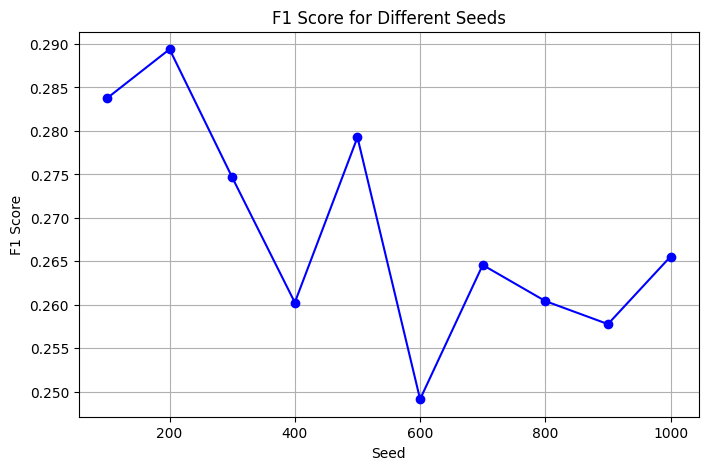

In [256]:
# Seed 범위 설정
seeds = [100, 200, 300,400, 500, 600, 700, 800,900,1000]

# F1 Score를 기록할 리스트 초기화
f1_scores = []
proba_results = {}
pred_results = {}

# Seed 값을 변경하며 모델 학습 및 평가
for seed in seeds:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

    # Voting
    voting_clf = VotingClassifier(
    estimators=[('cat1', model1), ('cat2', model2),('cat3', model3),('cat4', model4)
               ],
    voting='soft'  # soft, hard
            )

    # VotingClassifier 학습
    voting_clf.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = voting_clf.predict(X_val) ; y_proba = voting_clf.predict_proba(X_val)
    accuracy = accuracy_score(y_val, y_pred) ; precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred) ; f1 = f1_score(y_val, y_pred) ; conf_matrix = confusion_matrix(y_val, y_pred)

    # 결과 출력
    print(f"Accuracy: {accuracy:.4f}"); print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}"); print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:"); print(conf_matrix) ; print(pd.DataFrame(y_pred).value_counts())
    
    # F1 Score 기록
    f1_scores.append(f1)
    proba_results[seed] = y_proba
    pred_results[seed] = y_pred
    
    # 현재 seed에 대한 결과 출력
    print(f"Seed: {seed}, F1 Score: {f1:.4f}")

# 최대 및 최소 F1 점수와 해당 시드 출력
max_f1_score = max(f1_scores)
min_f1_score = min(f1_scores)
max_f1_seed = seeds[f1_scores.index(max_f1_score)]
min_f1_seed = seeds[f1_scores.index(min_f1_score)]

print(f"\nMax F1 Score: {max_f1_score:.4f} at Seed: {max_f1_seed}")
print(f"Min F1 Score: {min_f1_score:.4f} at Seed: {min_f1_seed}")

# F1 Score 평균 출력
mean_f1_score = pd.DataFrame(f1_scores).mean()
print(f"\nMean F1 Score: {mean_f1_score[0]:.4f}")

# F1 Score 플롯 그리기
plt.figure(figsize=(8, 5)) ; plt.plot(seeds, f1_scores, marker='o', linestyle='-', color='b')
plt.title('F1 Score for Different Seeds')
plt.xlabel('Seed') ; plt.ylabel('F1 Score') ; plt.grid(True) ; plt.show()

In [ ]:
# 함수정의
def voting_fold(seed, n_splits=5):  

    # StratifiedKFold 설정
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=seed)

    fold = 1
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # 모델 초기화 및 훈련
        voting_clf = VotingClassifier(
        estimators=[('cat1', model1), ('cat2', model2), ('cat3', model3),
                   ('cat4', model4), ('cat5', model5), ('cat6', model6)],
                    voting='soft'  # soft, hard
                        )

        # VotingClassifier 학습
        voting_clf.fit(X_train, y_train)

        # 예측 및 평가
        y_pred = voting_clf.predict(X_val) ; y_proba = voting_clf.predict_proba(X_val)

        # 성능 지표 계산
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        conf_matrix = confusion_matrix(y_val, y_pred)

        # 결과 출력
        print(f"Fold {fold}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print("\n")

        fold += 1

voting_fold(17,n_splits=5)       

# 5. Submission

In [290]:
# VotingClassifier 정의 (Soft Voting 사용)
voting_clf = VotingClassifier(
    estimators=[('cat1', model1), ('cat3', model3),('cat4', model4)],voting='soft'  # soft, hard
            )

# VotingClassifier 학습
voting_clf.fit(X, y)
# 예측 및 성능 평가
y_pred = voting_clf.predict(test_data)
pd.DataFrame(y_pred).value_counts()

0    16687
1      674
Name: count, dtype: int64

In [291]:
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred
df_sub['target'] = df_sub['target'].apply(lambda x: 'AbNormal' if x == 1 else 'Normal')
df_sub["target"].value_counts()

target
Normal      16687
AbNormal      674
Name: count, dtype: int64

In [292]:
#제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

## 단일모델 submission

In [293]:
params = {'iterations': 497,
        'depth': 8,
        'learning_rate': 0.021315242996735206,
        'class_weights': {0:1, 1:7.7},
        'l2_leaf_reg': 7}


In [294]:
model = CatBoostClassifier(**params, cat_features=categorical_cols, random_state=77, verbose=0, early_stopping_rounds  = 150, task_type='GPU', devices ='0')
model.fit(X, y)
y_pred = model.predict(test_data)
pd.DataFrame(y_pred).value_counts()

0    16822
1      539
Name: count, dtype: int64

In [295]:
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred
df_sub['target'] = df_sub['target'].apply(lambda x: 'AbNormal' if x == 1 else 'Normal')
df_sub["target"].value_counts()

target
Normal      16822
AbNormal      539
Name: count, dtype: int64

In [296]:
df_sub.to_csv("submission.csv")

In [297]:
#확인용
pd.read_csv("submission.csv")[['target']].value_counts()

target  
Normal      16822
AbNormal      539
Name: count, dtype: int64